# EDA

- Permite ao cientista tomar decisões críticas sobre o que é interessante perseguir, e assim construindo uma hipótese a partir do relacionamento entre as variáveis.

## Carregamento dos dados

In [1]:
import pandas as pd

In [105]:
ks = pd.read_csv('../../../datasets/ks-projects-201801.csv')
ks = ks.sample(30000, random_state=42).reset_index().drop('index', axis=1)  # ~10%

In [3]:
from utils import *
resumetable(ks)

Dataset Shape: (30000, 15)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,ID,int64,0,30000,1576537356,675907016,361890770,14.87
1,name,object,0,29983,Deko,"Westside BJ's: The Gluten-Free, Organic Food T...",Crepe Diem Food Truck,14.87
2,category,object,0,158,Hardware,Food Trucks,Food,6.26
3,main_category,object,0,15,Technology,Food,Food,3.57
4,currency,object,0,14,USD,USD,USD,1.28
5,deadline,object,0,2916,2015-10-24,2015-02-01,2014-01-17,11.23
6,goal,float64,0,1531,70000,250000,30000,6.55
7,launched,object,0,29997,2015-09-24 03:12:52,2015-01-02 20:55:07,2013-12-18 03:26:04,14.87
8,pledged,float64,0,10421,1888,1466,5723,10.72
9,state,object,0,6,failed,failed,failed,1.51


## Análise inicial

- Quais colunas não são úteis se desejamos predizer o sucesso (ou não) de um projeto?
  - De cara, sabemos que `ID` e `name` são desnecessárias.
  - `category` tem 158 valores únicos, então pode ser importante para classificação.
  - `main_category` com apenas 15 valores únicos talvez não seja útil sozinho, mas em combinação com outras features, como `category` pode importar mais.
    - Igualmente para os atributos `currency` ou `country`. Um ou outro porque pode ser que estejam correlacionados, logo adicionando uma redundância desnecessária.
  - `deadline`e `launched` são do formato `datetime`, podem ser úteis para indicar alguma tendência--por exemplo, melhor mês para iniciar/terminar o projeto.
     - Também podem ser úteis para derivar dados, como `campaign_time = deadline - launched`
  - `goal` e `pledged` estão na moeda indicada por `currency`, mas os atributos `usd_pledged_real` e `usd_goal_real` indicam a mesma coisa.
     - `usd pledged` indica o mesmo que `usd_pledged_real`: convesão de `pledged` para dólar, só que feito pelo time do kickstarter. 
     - `usd_pledged_real` (e `pledged`) é quanto o projeto conseguiu arrecadar. Para predição isso é inválido pois não se sabe seu valor à priori.
     - Sendo assim, podemos dropar `goal`, `pledged`, `usd pledged` e `usd_pledged_eal`.
       - Todavia, apesar de não sabermos o valor arrecadado à priori, pode ser útil para indicar que tipos de projetos arrecadam menos.
       - O mesmo vale para `backers`, que é quantos indivíduos ajudaram.
       - Vale notar que `usd pledged` tem valores faltando.
  - `state` é o resultado final, inicialmente dividido em 6 categorias: failed, canceled, successful, suspended, live, undefined.
    - Podemos dropar os projetos `live` e `undefined`, e juntar os `canceled` e `suspended` para `failed`.
    - No fim teremos apenas `successful` e `failed`.

## Limpeza

### Dropando os mais óbvios

- São: `ID`, `name`, porque não indicam nada relevante. `goal` e `pledged` porque temos `usd_pledged_real` e `usd_goal_real`. `usd pledged` pelo mesmo motivo anterior.

In [106]:
cols2drop = ['ID', 'name', 'goal', 'pledged', 'usd pledged',]
ks.drop(cols2drop, axis=1, inplace=True)

### Agregando `state` em duas categorias

In [107]:
ks = ks.query('state != "live" and state != "undefined"')
ks['state'] = ks.state.where(ks.state == 'successful', 'failed')
ks.groupby('state').size()

state
failed        18839
successful    10691
dtype: int64

- Talvez tenhamos um problema aí: temos quase o dobro de projetos falhos em relação a projetos bem sucedidos.
- Lembre, no entanto, que estamos usando uma amostra de 10% de todo o dataset.

In [108]:
resumetable(ks)

Dataset Shape: (29530, 10)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,category,object,0,158,Hardware,Food Trucks,Food,6.27
1,main_category,object,0,15,Technology,Food,Food,3.58
2,currency,object,0,14,USD,USD,USD,1.27
3,deadline,object,0,2886,2015-10-24,2015-02-01,2014-01-17,11.22
4,launched,object,0,29527,2015-09-24 03:12:52,2015-01-02 20:55:07,2013-12-18 03:26:04,14.85
5,state,object,0,2,failed,failed,failed,0.94
6,backers,int64,0,1220,41,9,90,6.61
7,country,object,0,23,US,US,US,1.40
8,usd_pledged_real,float64,0,13876,1888,1466,5723,11.42
9,usd_goal_real,float64,0,7092,70000,250000,30000,8.54


### Derivando dias de campanha

In [109]:
# Primeiro vamos converter as colunas com datas

ks['launched'] = pd.to_datetime(ks.launched)
ks['deadline'] = pd.to_datetime(ks.deadline)
ks['campaign_days'] = (ks.deadline - ks.launched).apply(lambda x: x.days)
ks.head(3)

,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,campaign_days
0,Hardware,Technology,USD,2015-10-24,2015-09-24 03:12:52,failed,41,US,1888.0,70000.0,29
1,Food Trucks,Food,USD,2015-02-01,2015-01-02 20:55:07,failed,9,US,1466.0,250000.0,29
2,Food,Food,USD,2014-01-17,2013-12-18 03:26:04,failed,90,US,5723.0,30000.0,29


- De cada data podemos obter o respectivo ano, mês e dia. São os dados que importam, e com eles podemos encontrar e visualizar possíveis relacionamento.
  - Pensando melhor: não vejo porque importaria a data fim (`deadline`) aqui. É mais útil saber a data de ínicio do projeto, dado que pode haver alguma tendência no período.
- As colunas originais podemos dropar.

In [110]:
ks = ks.assign(year=ks.launched.dt.year,
               month=ks.launched.dt.month,
               day=ks.launched.dt.day).drop(['launched', 'deadline'], axis=1)
ks.head(5)

,category,main_category,currency,state,backers,country,usd_pledged_real,usd_goal_real,campaign_days,year,month,day
0,Hardware,Technology,USD,failed,41,US,1888.00,70000.00,29,2015,9,24
1,Food Trucks,Food,USD,failed,9,US,1466.00,250000.00,29,2015,1,2
2,Food,Food,USD,failed,90,US,5723.00,30000.00,29,2013,12,18
3,Fiction,Publishing,GBP,failed,2,GB,31.09,6839.01,29,2016,10,24
4,Restaurants,Food,USD,failed,3,US,100.00,30000.00,59,2015,3,14


- Considerando que o objetivo da modelagem seja predizer o sucesso ou falha de um projeto, alguns dos atributos não são conhecidos à priori:
  - `backers`
  - `usd_pledged_real`
  - `campaign_days`
- Todavia isso não implica em que sejam inúteis; podem certamente ajudar a entender o comportamento de outras variáveis para com o objetivo.

### Aplicando um modelo básico: árvores de decisão

- Primeiro prepararemos os dados, logo então aplicaremos o modelo.

In [115]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

seed = 42  # Reproducidabilidade

enc = LabelEncoder()
cols2enc = ['category', 'main_category', 'currency', 'country']
data = ks.copy()
data[cols2enc] = ks[cols2enc].apply(enc.fit_transform)

x_train, x_test, y_train, y_test = train_test_split(data.drop(['state'], axis=1), data.state, test_size=0.2, random_state=seed)
clf = DecisionTreeClassifier(random_state=seed)
score = cross_val_score(clf, x_train, y_train, cv=5, n_jobs=-1)
print(score)

[0.98709268 0.98878544 0.98708721 0.98941575 0.98645216]


In [117]:
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier(random_state=seed)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print(acc)

0.9889942431425669


- Ótimo resultado, todavia usamos atributos que não temos à priori `usd_pledged_real`, `backers` e `campaign_days`. Vamos testar mais uma vez o modelo sem tais atributos.

In [128]:
data = ks.copy()

data[cols2enc] = ks[cols2enc].apply(enc.fit_transform)
data.drop(['backers', 'campaign_days', 'usd_pledged_real'], axis=1, inplace=True)

x_train, x_test, y_train, y_test = train_test_split(data.drop(['state'], axis=1), data.state, test_size=0.2, random_state=seed)

clf = DecisionTreeClassifier(random_state=seed)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print(acc)

0.5944801896376566


- Pois é... esperado. A razão é simples: projetos falhos tem um `usd_pledged_real` obviamente muito menor do que os projetos sucedidos.

### Eliminando outliers

- Podemos identificar outliers nas variáveis númericas utilizando de visualizações como **boxplot**.

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

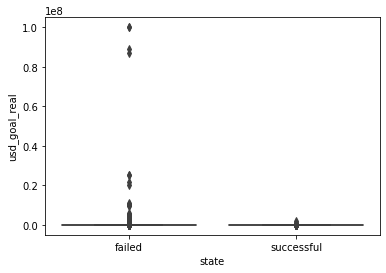

In [127]:
sns.boxplot(x=ks.state, y=ks.usd_goal_real)

- Aparentemente, projetos falhos exageram no objetivo. E isso **pode** ser útil para discriminar os projetos.
- Quantas amostras são potenciais outliers no que tange o `usd_goal_real`? E qual a proporção delas para o resultado final `state`?

In [142]:
Q1 = ks.usd_goal_real.quantile(0.25)
Q3 = ks.usd_goal_real.quantile(0.75)
IQR = Q3 - Q1
thresh = Q3 + (IQR * 1.5)
projects_above_thresh = ks.usd_goal_real > thresh
n_failed = (ks[projects_above_thresh].state == 'failed').sum()
n_successful = (ks[projects_above_thresh].state == 'successful').sum()
print(f"Failed projects proportion for usd_goal_real > {thresh:.2f} =  {n_failed/projects_above_thresh.sum():.2f}")
print(f"Successful projects proportion for usd_goal_real > {thresh:.2f} =  {n_successful/projects_above_thresh.sum():.2f}")

Failed projects proportion for usd_goal_real > 35728.49 =  0.87
Successful projects proportion for usd_goal_real > 35728.49 =  0.13


- Podemos dizer que projetos exitosos são mais realistas no que diz respeito as suas metas.
- Vamos tentar analisar quais categorias são mais exitosas ou não, e como se relacionam com seu objetivo.

### Mais visualizações

In [143]:
resumetable(ks)

Dataset Shape: (29530, 12)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,category,object,0,158,Hardware,Food Trucks,Food,6.27
1,main_category,object,0,15,Technology,Food,Food,3.58
2,currency,object,0,14,USD,USD,USD,1.27
3,state,object,0,2,failed,failed,failed,0.94
4,backers,int64,0,1220,41,9,90,6.61
5,country,object,0,23,US,US,US,1.40
6,usd_pledged_real,float64,0,13876,1888,1466,5723,11.42
7,usd_goal_real,float64,0,7092,70000,250000,30000,8.54
8,campaign_days,int64,0,92,29,29,29,3.80
9,year,int64,0,11,2015,2015,2013,2.87


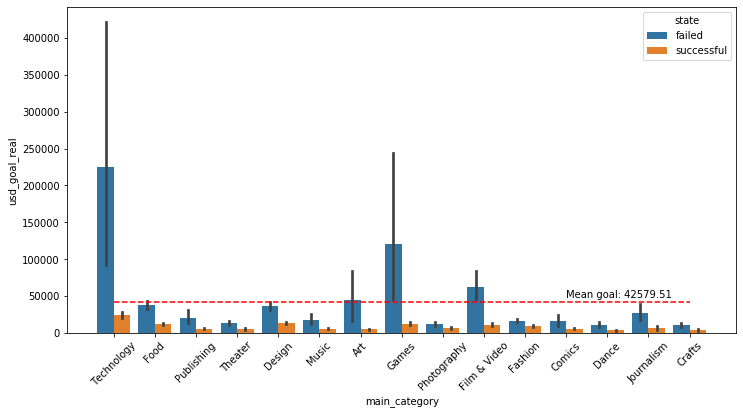

In [187]:
plt.figure(figsize=(12, 6))
g = sns.barplot(x='main_category', y='usd_goal_real', hue='state', data=ks)
g = g.set_xticklabels(g.get_xticklabels(), rotation=45)

mean_goal = ks.usd_goal_real.mean()
unique_mc = ks.main_category.unique().size
plt.plot(np.arange(unique_mc), [mean_goal] * unique_mc, '--r')
plt.text(unique_mc - 4, mean_goal + 5000, f'Mean goal: {mean_goal:.2f}')
plt.show()

- Note que a categoria principal de tecnologia exagera muito no objetivo em relação as demais. Em segundo lugar, vem **games**. Depois **Filmes e Videos**.
- Podemos ver como os países entram aí?

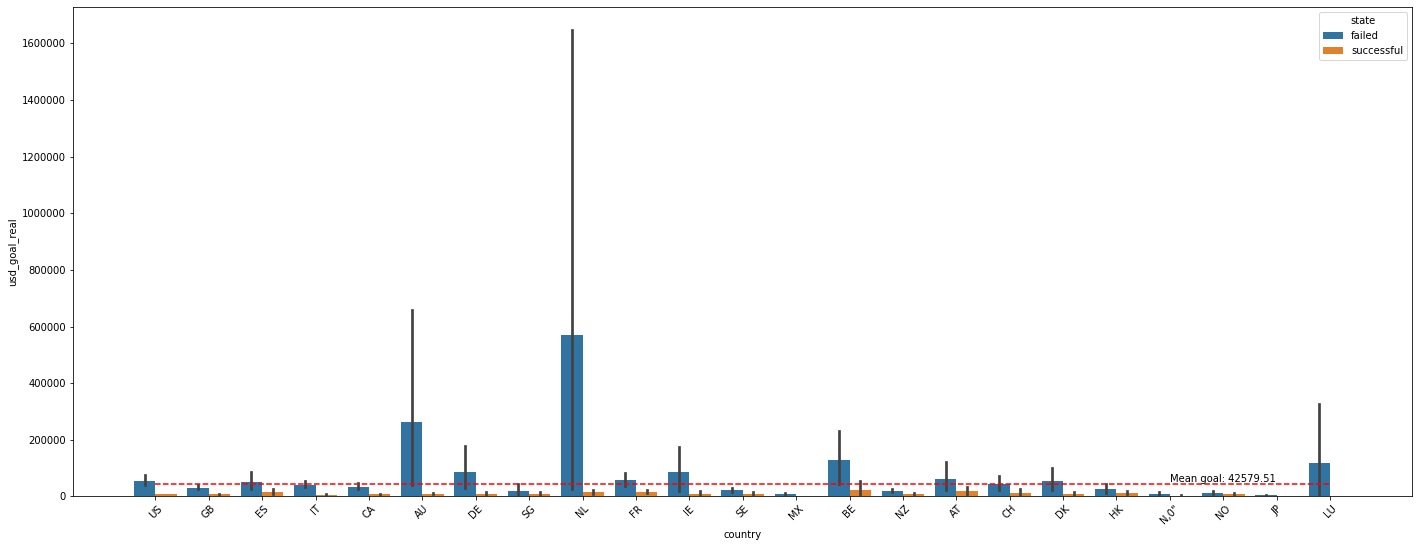

In [190]:
plt.figure(figsize=(24, 9))
g = sns.barplot(x='country', y='usd_goal_real', hue='state', data=ks)
g = g.set_xticklabels(g.get_xticklabels(), rotation=45)

mean_goal = ks.usd_goal_real.mean()
unique_countries = ks.country.unique().size
plt.plot(np.arange(unique_countries), [mean_goal] * unique_countries, '--r')
plt.text(unique_countries - 4, mean_goal + 7000, f'Mean goal: {mean_goal:.2f}')
plt.show()

- Razoável. Apenas algun saem *muit* da média: AU, NL, LU. 

- **Importante**: muitas amostras com razão pledged/goal > 1. Isso **pode** significar ruído?

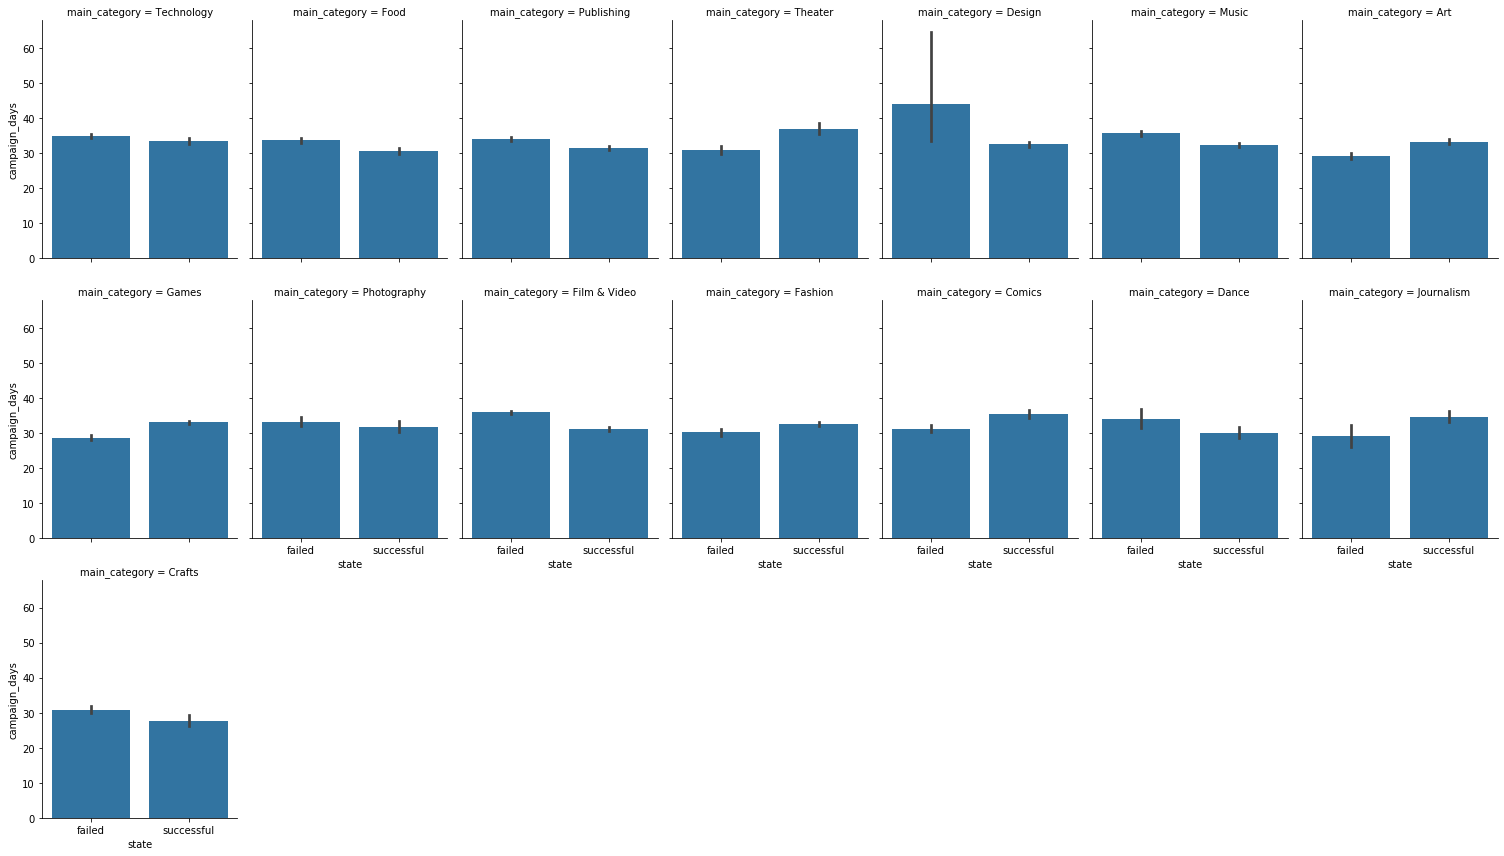

In [256]:
g = sns.FacetGrid(ks, col='main_category', col_wrap=7, height=4., aspect=.75)
g.map(sns.barplot, "state", "campaign_days")

## Recursos

- https://towardsdatascience.com/hitchhikers-guide-to-exploratory-data-analysis-6e8d896d3f7e